In [2]:
%%capture
## compile PyRossTSI for this notebook
import os
owd = os.getcwd()
os.chdir('../..')
%run setup.py install
os.chdir(owd)

In [3]:
import pyrosstsi
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [4]:
T = 15                                       # Longest  infectious duration
Td = 5                                       # Doubling time in linear growth regime
Tf = 150                                     # Duration of simulation

tsi  = np.array([0,   3,    5,   10,   T])   # Time since infection (days)
beta = np.array([0,   0.5,  1,   .5,   0])   # Mean infectiousness 

M = 2                                        # Number of age groups to model
Ni = 10**6*np.ones(M)                        # Number of people in each age group
Np = sum(Ni)                                 # Total population size

#how many 'stages' to resolve in time since infection?
Nk = 10

#define a time-dependent contact matrix.
#variations on timescale less than T/Nk may not be resolved.
def contactMatrix(t):
    if t > 30 and t < 45:
        return 0.1*np.array([[4, 1],[1, 2]])
    else:
        return np.array([[4, 1],[1, 2]]); 

subclasses = ['Recovered', 'Hospitalized', 'Mortality']  
pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
pD = 1-pR;             #probability of death for each age class

#prepare for a linear interpolating function evaluated at times:
tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])   

phiR     = np.array([0,    0,    0.5,   3,     2,     0])  #rate of transferring to 'recovered' (arbitrary units)
phiH_in  = np.array([0,    0,    1,     1,     0,     0])  #rate that people enter hospital     (arbitrary units)
phiH_out = np.array([0,    0,    0,     1,     1,     0])  #rate that people enter hospital     (arbitrary units)
phiD     = np.array([0,    0,    0,     1,     1,    .5])  #times at which a person dies        (arbitrary units)

#combine hospital in/out to a single function for net change in hospitalized cases
phiH = np.add(-phiH_out/np.trapz(phiH_out,tsi_sc),phiH_in/np.trapz(phiH_in,tsi_sc))

#normalize all to one -- can then be rescaled by approprate pR, pH, pD, etc. at a later time
phiR,  phiD  = phiR/np.trapz(phiR,tsi_sc),  phiD/np.trapz(phiD,tsi_sc)

#group them all together for later processing
phi_alpha, p_alpha = np.array([phiR, phiH, phiD])*T/2, np.array([pR, pH, pD])

In [5]:
              
parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta,'tsi_sc':tsi_sc,'contactMatrix':contactMatrix}

model = pyrosstsi.deterministic.Simulator(parameters, phi_alpha, p_alpha)
IC    = model.get_IC()
data  = model.simulate(IC)

## Plot the results

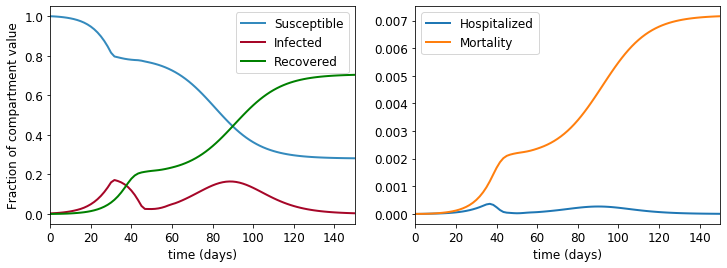

In [6]:
#unpack and rescale simulation output
t = data['t']*T/2; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);   